In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)


# Машинное обучение и майнинг данных

## 09/02/2017 Деревья решений, оценка качества алгоритмов

## В предыдущий раз..

Мы рассматривали метрические методы классификации (k-ближайших соседей)

* kNN - "ленивый", непараметрический метод машинного обучения
* Гиперпараметры: мера близости, количество соседей, ядро, ширина ядра
* Просто "запоминаем" обучающую выборку и используем ее для предсказания
* Сложно интерпретировать результат


<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/220px-KnnClassification.svg.png' width=400></center>

## Пример 1

* Некоторый ВУЗ открыл программу ДПО по разработке приложений на Andriod
* Прошло уже несколько наборов
* По результатам каждого отбора слушатели отставляют отзыв (`+1`|`-1`)
* О слушателях известно
    * Пол
    * Возраст
    * Образование
    * Посещаемость
    * Оценки за ДЗ
    * ...
    
ВУЗ просит у исследователя описать те группы слушателей, которым курс не понравился, чтобы возможно как-то его улучшить.

В идеальном мире исследователь должен прийти с чем-то вроде

* `[Пол = М][Возраст > 30][Образование = Экономика][Посещаемость < 50%]`  - не нравится в 82% случаев
* `[Пол = Ж][Возраст < 25][Возраст >= 20][Образование = Математика][Средний балл < 5]` - не нравится в 74% случаев
* ...


## Пример 2

* Вы приходите в банк за кредитом ~~не дай бог~~, подаете анкету со всеми необходимыми документами
* Сотрудник банка проверяет вашу анкету:
    1. Если объем сбережений <= 200 тыс., то перейти к шагу 2, иначе - к шагу 3.
    2. Если стаж больше года - дать кредит, иначе - не давать
    3. Если продолжительность займа < 30 месяцев - не давать кредит, иначе - к шагу 4
    4. ...

<center><img src='https://www.mapr.com/sites/default/files/blogimages/creditdecisiontree.png'><center/>

<center><img src='https://media.licdn.com/mpr/mpr/shrinknp_800_800/AAEAAQAAAAAAAAZ5AAAAJGU4MGQyYzM2LTY2ZjgtNGYzYi04NWEyLTVkZGU3ODUxNjljNw.png'></center>

<center><img src='https://i.stack.imgur.com/KYSy4.png'></center>

<center><img src='https://static01.nyt.com/images/2008/04/16/us/0416-nat-subOBAMA.jpg'><center/>

<center><img src='http://thegrimmscientist.com/content/images/2014/Oct/plot_d2-1.png'></center>

<center><img src='http://scikit-learn.org/stable/_static/ml_map.png'><center/>

<center><img src='https://eight2late.files.wordpress.com/2016/02/7214525854_733237dd83_z1.jpg?w=700'><center/>

Формально, дерево решений - это связный ациклический граф. В нем можно выделить 3 типа вершин:
1. Корневая вершина (root node) -  откуда все начинается
2. Внутренние вершины (intermediate nodes)
3. Листья (leafs) - самые глубокие вершины дерева, в которых содержится "ответ"

Во внутренней или коневой вершине признак проверяется на некий логический критерий, по результатам которого мы движемся все глубже

## Обобщенный псевдокод алгоритма построения дерева


```{python}
function decision_tree(X, y):

    if stopping_criterion(X, y) == True:
    
        S = create_leaf_with_prediction(y)
        
    else:
    
        S = create_node()
        (X_1, y_1) .. (X_L, y_L) = best_split(X, y)
        
        for i in 1..L:
            C = decision_tree(X_i, y_i)
            connect_nodes(S, C)
    return S     
```

## Как определяются лучшие разбиения (best splits)?
### Меры неопределенности (impurity measures)

По какому мешку лучше классифицировать?

<center><img src='bins.png'></center>


## Как определяются лучшие разбиения (best splits)?
### Меры неопределенности (impurity measures)

Пусть $p_k$ - это доля класса $C_k$ в узле дерева $S$.

1. Missclassification error  
$$I(S) = 1 - \max\limits_k p_k $$
2. Gini index 
$$I(S) = 1 - \sum\limits_k (p_k)^2 = \sum\limits_{k'\neq k} p_{k'} p_k$$
3. Entropy 
$$I(S) = -\sum\limits_k p_k \log(p_k)$$


In [18]:
def plot_impurities():
    p = np.linspace(0, 1, 100)
    p = np.c_[p, 1-p]

    missclass = 1 - p.max(axis=1)
    plt.plot(p[:,0], missclass, label = 'missclassification error')

    gini = 1 - (p ** 2).sum(axis=1)
    plt.plot(p[:,0], gini, label = 'gini index')

    entropy = - np.nansum((p*np.log2(p)), axis=1)
    plt.plot(p[:,0], entropy, label = 'entropy')

    plt.xlabel('$p_k$')
    plt.ylabel('$I(S)$')
    # plt.legend(loc=2, bbox_to_anchor=(0.,0.))
    plt.legend(loc=2, bbox_to_anchor=(-0.3,1))

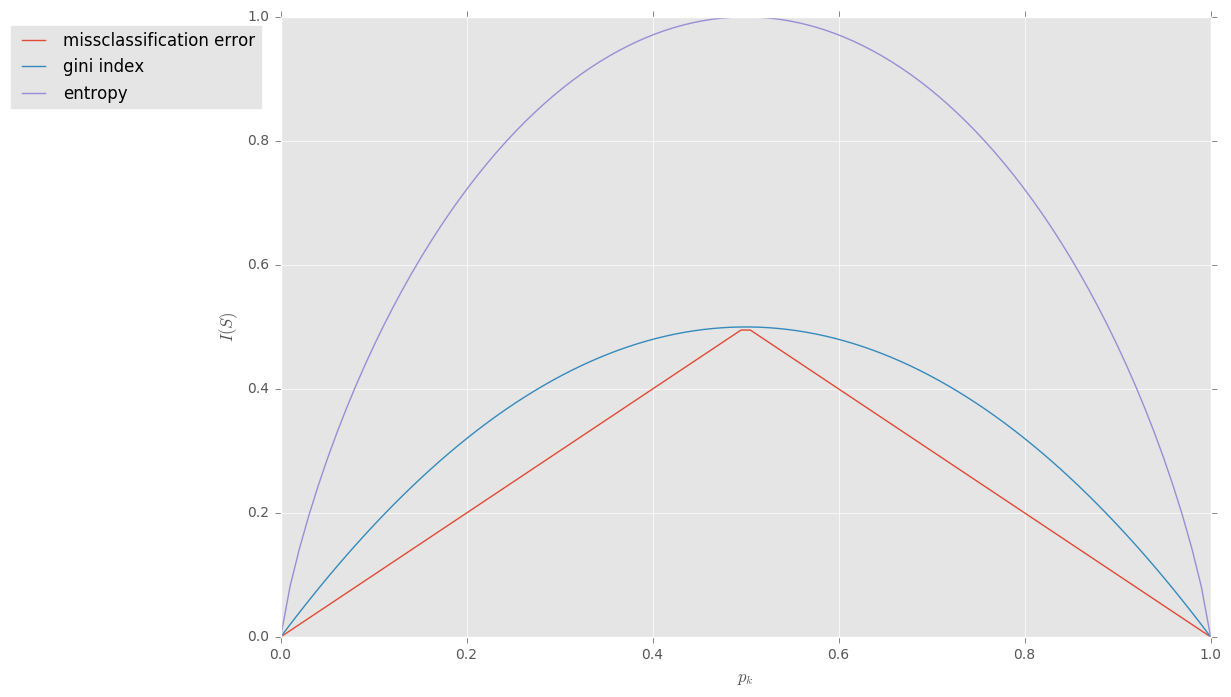

In [19]:
plot_impurities()

## Как определяются лучшие разбиения (best splits)?
### Прирост информации

Выберем признак $A$ и пороговое значение $t$ на нем таким образом, чтобы уменьшить неопределенность:

**Насколько уменьшится неопределенность:** <br/>
$$ Gain(S, A) = I(S) - \left(\frac{|S_L|}{|S|}\cdot I(S_L) + \frac{|S_R|}{|S|}\cdot I(S_R) \right),$$ где $S_R$ и $S_L$ - это потомки узла $S$ c объектами, удовлетворяющим соответствующим условиям.

* Стратегия выбора - жадная
* Как определяется порог при вещественных признаках?
* Локальная оптимизация - уменьшение Impurity внутри узла
* Результаты не сильно зависят от выбора самой меры неопределенности


In [4]:
def gini_impurity(p):
    return 1 - (p**2).sum()

def wine_demo():

    df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

    fig, ax = plt.subplots(1, 2)

    fig.set_figheight(5)

    df_wine.loc[:, 'quality_cat'] = (df_wine.loc[:, 'quality'] > 5).astype(int) 
    idx = df_wine.loc[:, 'quality_cat'] == 1
    df_wine.loc[idx, 'alcohol'].hist(label='good quality', bins=20, alpha = 0.4, ax=ax[0])
    df_wine.loc[~idx, 'alcohol'].hist(label='bad quality', bins=20, alpha = 0.4, ax=ax[0])
    ax[0].set_xlabel('alcohol')

    p = np.array([df_wine.quality_cat.mean(), 1-df_wine.quality_cat.mean()])

    init_impurity = gini_impurity(p)

    G = []
    t_range = np.linspace(df_wine.alcohol.min(), df_wine.alcohol.max(), 100)

    for t in t_range:
        idx = df_wine.alcohol < t
        p1 = np.array([df_wine.loc[idx, 'quality_cat'].mean(), 1-df_wine.loc[idx, 'quality_cat'].mean()])
        p2 = np.array([df_wine.loc[~idx, 'quality_cat'].mean(), 1-df_wine.loc[~idx, 'quality_cat'].mean()])

        G.append(init_impurity - (idx.mean()*gini_impurity(p1) + (1-idx.mean())*gini_impurity(p2)))

    ax[1].plot(t_range, G)
    ax[1].set_xlabel('alcohol')
    ax[1].set_ylabel('Gain')

    mG = np.nanmax(G)
    mt = t_range[np.nanargmax(G)]

    ax[0].vlines(mt, 0, 150, label='best threshold (%.2f)' % mt)
    ax[1].vlines(mt, 0, mG, label='best threshold\n(gain = %.4f)' % mG)
    
    ax[0].legend()
    ax[1].legend()

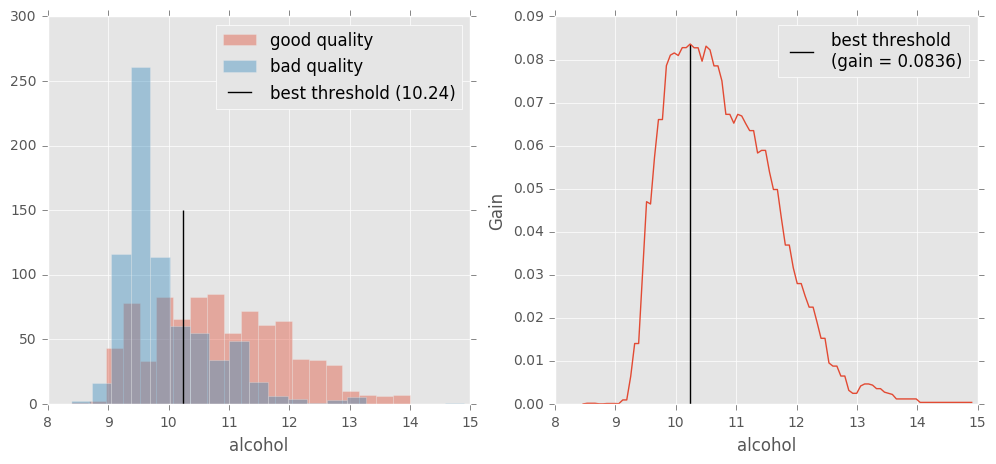

In [5]:
wine_demo() 

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from ipywidgets import interact, IntSlider
import subprocess


def demo_dec_tree(depth=1):
    fig, ax = plt.subplots(1,2)
    fig.set_figheight(5)

    np.random.seed(0)

    C = np.array([[0., -0.7], [1.5, 0.7]])
    gauss1 = np.dot(np.random.randn(200, 2) + np.array([4, 2]), C)
    gauss2 = np.dot(np.random.randn(300, 2), C)

    X = np.vstack([gauss1, gauss2])
    y = np.r_[np.ones(200), np.zeros(300)]

    ax[1].scatter(X[:,0], X[:, 1], c=y)
    ax[1].set_xlabel('$x_1$')
    ax[1].set_ylabel('$x_2$')

    # Dec Tree Stuff
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=123)
    tree.fit(X,y)

    x_range = np.linspace(X.min(), X.max(), 100)
    xx1, xx2 = np.meshgrid(x_range, x_range)

    Y = tree.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Y = Y.reshape(xx1.shape)

    ax[1].contourf(xx1, xx2, Y, alpha=0.3)
    ax[1].scatter(X[:,0], X[:,1],c=y)

    with open('tree.dot', 'w') as fout:
        export_graphviz(tree, out_file=fout, feature_names=['x1', 'x2'], class_names=['0', '1'])
    command = ["dot", "-Tpng", "tree.dot", "-o", "tree.png"]
    subprocess.check_call(command)
    ax[0].imshow(plt.imread('tree.png'))
    ax[0].axis("off")

## Классификация

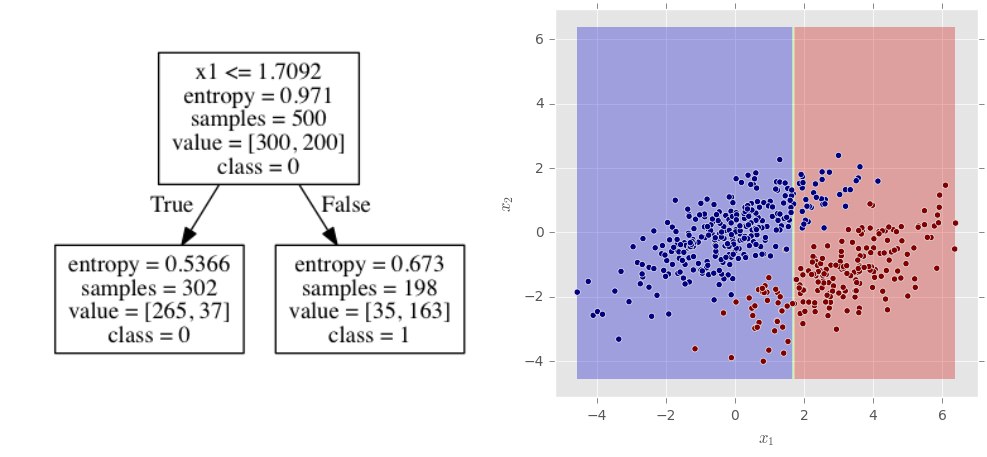

In [7]:
try:
    fig = interact(demo_dec_tree, depth=IntSlider(min=1, max=5, value=1))
except:
    print 'Что-то не так. Посмотрите на доску'

## Критерии останова (регуляризация)

* Никогда
* Задать порог по мере неопределенности: $I(S) \leq \theta$
* Задать порог по размеру узла: $|S| \leq n$
* Задать порог на глубину: $Depth(S) = d$
* Задать порог на размер потомков: $|S_L| \leq n_1 \& |S_R| \leq n_2$
* ...

## Регрессия

Для задачи регрессии в качестве меры неопределенности могут выступать

* Среднее квадратичное отклонение от среднего
$$ I(S) = \frac{1}{|S|}\sum\limits_{i \in S}(y_i - \bar{y_S})^2 $$
* Среднее абсолютное отклонение от медианы
$$ I(S) = \frac{1}{|S|}\sum\limits_{i \in S}|y_i - \bar{y_S}| $$

In [8]:
from sklearn.tree import DecisionTreeRegressor

x_true = np.arange(-5, 5, 0.2)
x = x_true + np.random.rand(x_true.shape[0]) - 0.5
y_true = np.sin(x_true)+x_true/3
y = y_true + np.random.rand(x_true.shape[0]) - 0.5

def plot_dec_reg(depth=1, criterion='mse', ):
    
    fig, ax = plt.subplots(1,2)
    fig.set_figheight(5)
    
    tree = DecisionTreeRegressor(criterion=criterion, max_depth=depth)
    tree.fit(x.reshape(-1,1), y)
    y_hat = tree.predict(x_true.reshape(-1,1))
    
    ax[1].plot(x_true, y_true, c='g', label='$f(x)$')
    ax[1].scatter(x, y, label='actual data')
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    ax[1].plot(x_true, y_hat, c='r', label='decision tree \nregression')
    ax[1].legend(loc=2)
    
    with open('tree.dot', 'w') as fout:
        export_graphviz(tree, out_file=fout, feature_names=['x1', 'x2'], class_names=['0', '1'])
    command = ["dot", "-Tpng", "tree.dot", "-o", "tree.png"]
    subprocess.check_call(command)
    ax[0].imshow(plt.imread('tree.png'))
    ax[0].axis("off")

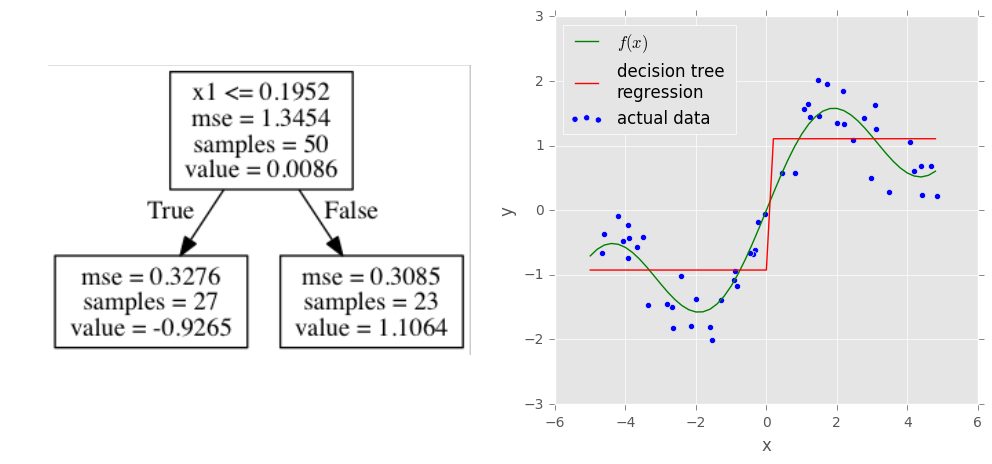

In [9]:
try:
    fig = interact(plot_dec_reg, depth=IntSlider(min=1, max=5, value=1), criterion=['mse', 'mae'])
except:
    print 'Что-то не так. Посмотрите на доску'

## Как определяется ответ?

* Классификация
    * Класс с большинством в листе
    * Доли каждого из классов в листе
* Регрессия
    * Среднее (медиана) целевой переменной в листе

## Важность признаков

В деревьях решений производится автоматический отбор признаков.

Пусть $v(S)$ - это признак, который использовался для ветвления в узле $S$

$$ \text{imp}(A) = \sum\limits_{i: v(S_i) = A} \frac{|S_i|}{|S|} Gain(S_i, A) $$

## Работа с пропусками

1. Удалить объекты\признаки с пропусками
2. Пропущенное значение = отдельная категория
3. Вычисление impurity без учета пропуска
4. Surrogate split

## Специальные алгоритмы построения деревьев
 
 
** ID 3 **
* Только категориальные признаки
* Количество потомков = количеству значений признака
* Строится до максимальной глубины

** С 4.5 **
* Поддержка вещественных признаков
* Категриальные как в ID3
* При пропуске значения переход по всем потомкам
* Удаляет избыточные ветвления

** СART **
* В основном сегодняшнее занятие про него
* Специальная процедура усещения дерева после построения (post prunning)

## Преимущества / Недостатки

** Преимущества **
* Простота построения
* Интерпретируемость (при небольшой глубине)
* Требуются минимальная предобработка признаков
* Встроенный отбор признаков



** Недостатки **
* Границы строяется только параллельно или перпендикулярно осям
* При изменении набора данных надо полностью перестраивать и результат может получится совершенно иным
* Жадность построения

# Случайный лес (Random Forest)

Дерево решений очень чувствительно к данным

In [10]:
from sklearn.datasets import make_moons

def demo_2dec_tree():
    fig, ax = plt.subplots(1,2)
    fig.set_figheight(5)

    np.random.seed(0)
    
    X, y = make_moons(noise=0.3, random_state=123)
    
    # Dec Tree Stuff
    for i in range(2):
        idx = np.random.randint(0, X.shape[0], int(0.9*X.shape[0]))

        X1 = X[idx, :]
        y1 = y[idx]

        ax[i].scatter(X1[:,0], X1[:, 1], c=y1)
        ax[i].set_xlabel('$x_1$')
        ax[i].set_ylabel('$x_2$')

        # Dec Tree Stuff 2
        tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=123)
        tree.fit(X1,y1)

        x_range = np.linspace(X.min(), X.max(), 100)
        xx1, xx2 = np.meshgrid(x_range, x_range)

        Y = tree.predict(np.c_[xx1.ravel(), xx2.ravel()])
        Y = Y.reshape(xx1.shape)

        ax[i].contourf(xx1, xx2, Y, alpha=0.3)
        ax[i].scatter(X[:,0], X[:,1],c=y)

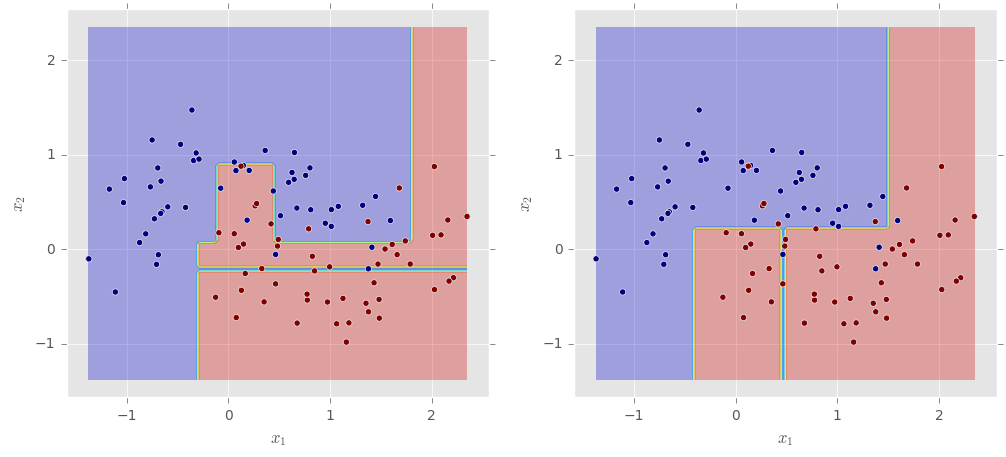

In [11]:
demo_2dec_tree()

Bagging - это параллельный способ построения ансамбля.<br/>
1. Обучающая выборка сэмплируется $k$ раз с помощью *bootstrap'a* (выборка с возвратом)
2. На каждом сэмпле обучается отдельная **базовая модель**
3. Ответы моделей усредняются (возможно с весом)
<center><img src='http://image.slidesharecdn.com/ipbimprovingthemodelspredictivepowerwithensembleapproaches-121203224610-phpapp02/95/improving-the-models-predictive-power-with-ensemble-approaches-10-638.jpg?cb=1354575467' width='750'></center>

*Вопрос: Какая доля объектов в среднем попадает в один bootstrap сэмпл?*

In [12]:
from sklearn.ensemble import RandomForestClassifier

def rf_demo(n_est=5):
    rf = RandomForestClassifier(random_state=123, n_estimators=n_est)

    np.random.seed(0)
    
    X, y = make_moons(noise=0.3, random_state=123)
    rf.fit(X, y)
    
    x_range = np.linspace(X.min(), X.max(), 100)
    xx1, xx2 = np.meshgrid(x_range, x_range)
    
    
    for tree in rf.estimators_:
        y_hat = tree.predict(np.c_[xx1.ravel(), xx2.ravel()])
        y_hat = y_hat.reshape(xx1.shape)

        plt.contourf(xx1, xx2, y_hat, alpha=1.0/n_est)
    plt.scatter(X[:,0], X[:,1], c=y)
    
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    
    plt.title('N estimators = %d' % n_est)



Так же есть некоторые обобщения этого подхода:

* Метод случайных подпространств - на шаге 1. сэмплируются не только объекты, но и подпространство признаков
* Метод случайного леса - на каждом узле сэмплируется подпространство признаков

В данном случае, на каждом сэмпле базовой моделью является дерево решений.<br/>
Если вам нужно за минимальное время построить достаточно точную и устойчивую модель - это ваш вариант.

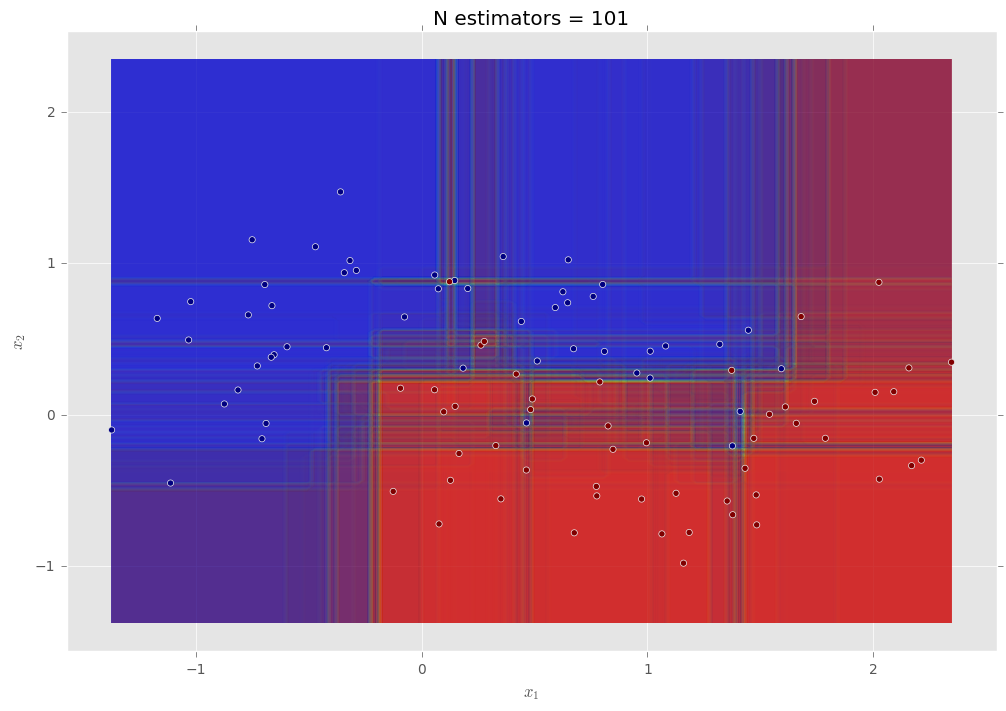

In [13]:
try:
    fig = interact(rf_demo, n_est=IntSlider(min=1, max=101, value=1, step=5))
except:
    print 'Что-то не так. Посмотрите на доску'

## Полезные ссылки
* [Визуализация работы деревьев](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)

# Метрики качества алгоритмов

<center><img src='https://dataengr.files.wordpress.com/2016/01/partitions.jpg?w=656'></center>

<center><img src='http://blog-test.goldenhelix.com/wp-content/uploads/2015/04/B-fig-1.jpg'></center>

## Регрессия


Пусть $y^{(i)}$ - значение целевого признака для $i$-го объекта, а $\hat{y}^{(i)}=a(x^{(i)})$ - её оценка алгоритмом $a(x)$.Чаще всего качество регрессионных методов оценивается по следующим функциям потерь:

**1. (R)MSE ((Root) Mean Squared Error) - (Корень из) Среднеквадратичное отклонение**

$$ L(a, y) = \frac{1}{N}\sum\limits_i^N (y^{(i)} - \hat{y}^{(i)})^2$$

**2. MAE (Mean Absolute Error) - Среднее абсолютное отклонение**

$$ L(a, y) = \frac{1}{N}\sum\limits_i |y^{(i)} - \hat{y}^{(i)}|$$


**3. RSE (Relative Squared Error) - Относительное квадратичное отклонение**

$$ L(a, y) = \sqrt\frac{\sum\limits_i (y^{(i)} - \hat{y}^{(i)})^2}{\sum\limits_i (y^{(i)} - \bar{y})^2}$$

**4. RAE (Relative Absolute Error) - Относительное абсолютное отклонение (?)**

$$ L(a, y) = \frac{\sum\limits_i |y^{(i)} - \hat{y}^{(i)}|}{\sum\limits_i |y^{(i)} - \bar{y}|}$$


**5. RMSLE (Root Mean Squared Logarithmic Error) - (?!)**

$$ L(a, y) = \sqrt{\frac{1}{N}\sum\limits_i^N(\log(y^{(i)} + 1) - \log(\hat{y}^{(i)} + 1))^2}$$

**6. Под предметную область **
* Стоимость заморозки средств, стоимость хранения товара и тп


* Как интерпретируются ошибки (3) и (4)?
* В чем особенность ошибки (5)?

In [14]:
def rmsle_demo(y=100):
    y_hat = np.linspace(0, 3*y, 151)
    # log error
    error1 = np.sqrt((np.log(y+1) - np.log(y_hat + 1))**2)

    # squared error
    error2 = (y - y_hat)**2 /1000.

    plt.plot(y_hat, error1, label='RMSLE')
    plt.plot(y_hat, error2, label='MSE')
    plt.xlabel('$\hat{y}$')
    plt.ylabel('Error')
    plt.title('true value y = %.1f' % y)
    plt.legend()
    plt.ylim(0, 10)

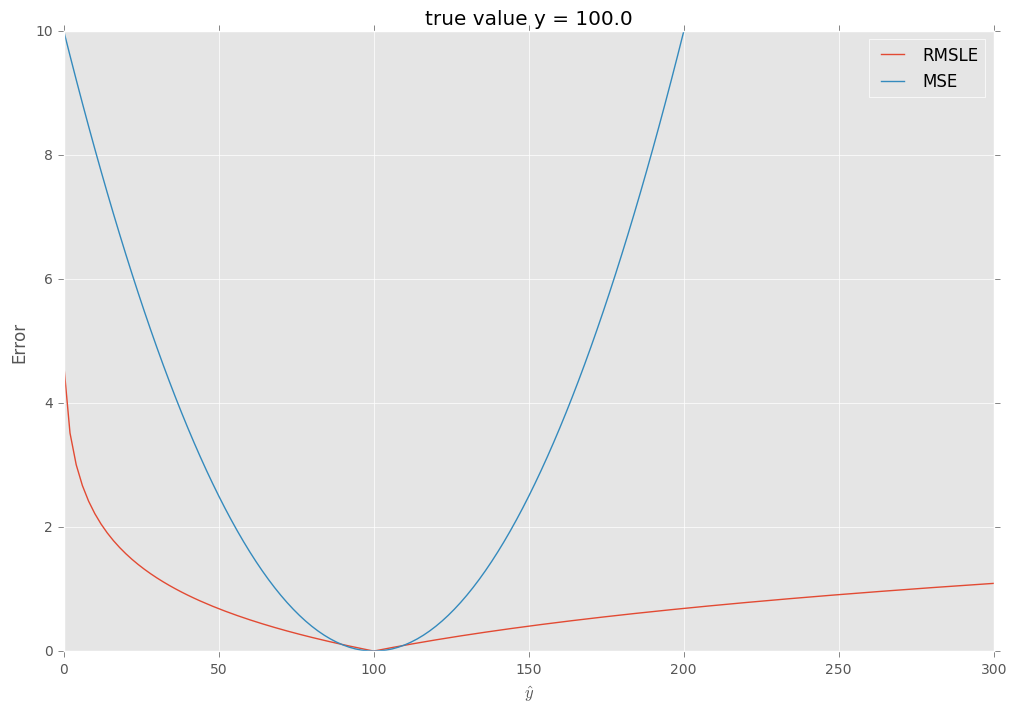

In [15]:
try:
    fig = interact(rmsle_demo, y=[100, 1000, 1000000])
except:
    print 'Что-то не так. Посмотрите на доску'

## Классификация

Рассмотрим случай бинарной классификации.

Пусть $y^{(i)}$ - истинная метка класса для $i$-го объекта, а $\hat{y}^{(i)}=a(x^{(i)})$ - метка, полученная алгоритмом.


<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;border:none;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;}
.tg .tg-s6z2{text-align:center}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-yw4l{vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-031e" colspan="2" rowspan="2"><br></th>
    <th class="tg-s6z2" colspan="2">Истинное значение</th>
  </tr>
  <tr>
    <td class="tg-s6z2">1</td>
    <td class="tg-baqh">0</td>
  </tr>
  <tr>
    <td class="tg-031e" rowspan="2">Предсказание</td>
    <td class="tg-s6z2">1</td>
    <td class="tg-s6z2">TP<br></td>
    <td class="tg-baqh">FP</td>
  </tr>
  <tr>
    <td class="tg-baqh">0</td>
    <td class="tg-baqh">FN<br></td>
    <td class="tg-baqh">TN</td>
  </tr>
  <tr>
    <td class="tg-yw4l"></td>
    <td class="tg-baqh"></td>
    <td class="tg-baqh">Pos<br></td>
    <td class="tg-baqh">Neg</td>
  </tr>
</table>

* TP (true positive) - количество верно предсказанных объектов класса 1
* FP (false positive) - количестно неверно  предсказанных объектов класса 0 (ошибка первого рода)
* FN (false negative) - количестно неверно  предсказанных объектов класса 1 (ошибка второго рода)
* TN (true negative) - количестно верно  предсказанных объектов класса 0

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;border:none;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;}
.tg .tg-s6z2{text-align:center}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-yw4l{vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-031e" colspan="2" rowspan="2"><br></th>
    <th class="tg-s6z2" colspan="2">Истинное значение</th>
  </tr>
  <tr>
    <td class="tg-s6z2">1</td>
    <td class="tg-baqh">0</td>
  </tr>
  <tr>
    <td class="tg-031e" rowspan="2">Предсказание</td>
    <td class="tg-s6z2">1</td>
    <td class="tg-s6z2">TP<br></td>
    <td class="tg-baqh">FP</td>
  </tr>
  <tr>
    <td class="tg-baqh">0</td>
    <td class="tg-baqh">FN<br></td>
    <td class="tg-baqh">TN</td>
  </tr>
  <tr>
    <td class="tg-yw4l"></td>
    <td class="tg-baqh"></td>
    <td class="tg-baqh">Pos<br></td>
    <td class="tg-baqh">Neg</td>
  </tr>
</table>

* $ \text{accuracy} = \frac{TP + TN}{Pos+Neg}$
* $ \text{error rate} = 1 -\text{accuracy}$
* $ \text{recall} =\frac{TP}{TP + FN} = \frac{TP}{Pos}$ - полнота
* $ \text{precision} =\frac{TP}{TP + FP}$ - точность
* $ \text{F}_\beta \text{-score} = (1 + \beta^2) \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{(\beta^2 \cdot \mathrm{precision}) + \mathrm{recall}}$



In [16]:
from mpl_toolkits.mplot3d import Axes3D


def demo_fscore(beta=1):
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    prec = np.linspace(0, 1, 100)
    rec = np.linspace(0, 1, 100)
    
    P, R = np.meshgrid(prec, rec)
    
    F = (1 + beta**2) * (P*R)/((beta**2 * P) + R)
    
    # Plot the surface.
    surf = ax.plot_surface(P, R, F, cmap=plt.cm.coolwarm, alpha=0.3,
                               linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(-0.01, 1.01)
    
    ax.view_init(30,200)
    ax.set_xlabel('precision')
    ax.set_ylabel('recall')
    ax.set_zlabel('F-score')
    ax.set_title('beta = %.2f'%beta)

    # Add a color bar which maps values to colors.
    fig.colorbar(surf)
    
   

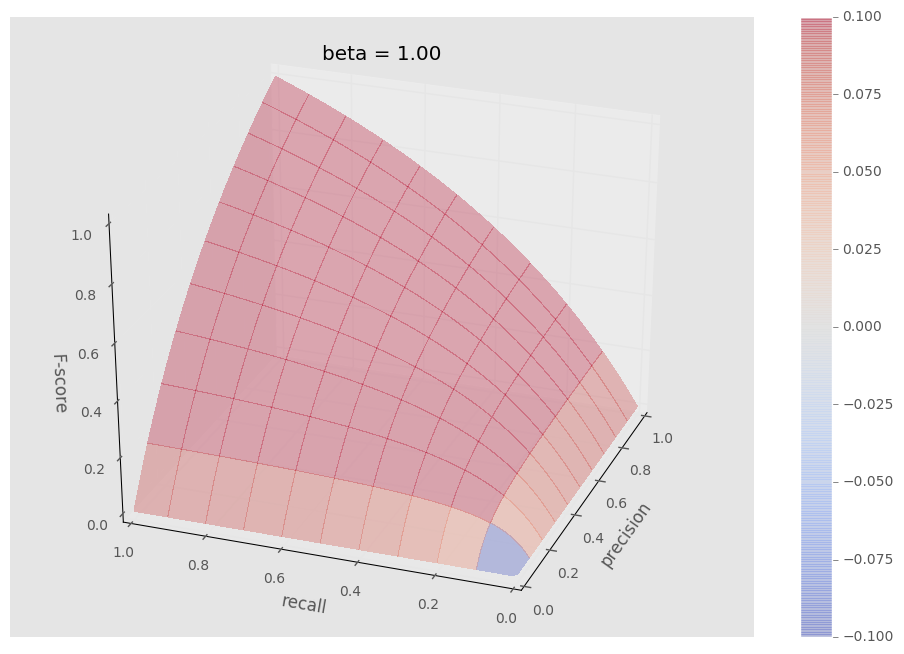

In [17]:
from ipywidgets import FloatSlider
try:
    fig = interact(demo_fscore, beta=FloatSlider(min=0.1, max=5, step=0.3, value=1))
except:
    print 'Что-то не так. Посмотрите на доску'

## ROC-кривая

Рассмотрим случай бинарной классификации.

Пусть $y^{(i)}$ - истинная метка класса для $i$-го объекта, а $\hat{y_{prob}}^{(i)}=a(x^{(i)})$ - вероятность (скор), с которой алгоритм относит объект  $i$  к классу $+1$.

* $TPR = \frac{TP}{TP + FN}=\frac{TP}{Pos}$,  $FPR = \frac{FP}{FP + TN} = \frac{FP}{FP + TN}$

Алгоритм:
1. Отсортировать объеты по убыванию скора
2. Начинаем в точке (0,0). Постепенно опускаем порог.
    * Если встречается объекта из класса $+1$ - поднимаемся на  $\frac{1}{Pos} вверх$
    * Если встречается объекта из класса $-1$ - передвигаемся на  $\frac{1}{Neg} влево$

* $TPR = \frac{TP}{TP + FN}=\frac{TP}{Pos}$,  $FPR = \frac{FP}{FP + TN} = \frac{FP}{Neg}$

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
</style>
<table class="tg">
  <tr>
    <th class="tg-031e"><img src='roc1.png'></th>
    <th class="tg-031e"><img src='roc2.png'></th>
  </tr>
</table>




<center><img src='https://openi.nlm.nih.gov/imgs/512/261/3861891/PMC3861891_CG-14-397_F10.png'></center>

* ROC-AUC (area under curve) - площадь под ROC кривой.
* Gini coeffisient - аналог этой меры

## PR - кривая

* Строится аналогичным образом при разных порогах.
* Можно посчитать площадь под кривой - PR-AUC

<center><img src='http://scikit-learn.org/stable/_images/sphx_glr_plot_precision_recall_001.png'></center>

## Model Lift

* Пусть $r_{POS}$ - доля положительного класса в наборе данных
* Пусть $TPR @ K\%$ - доля положительного класса в  первых $K \%$ объектов, отсортированных по убыванию скора

 $$ Model Lift @ K\% = \frac{TPR @ K\%}{r_{POS}} $$

<center><img src='http://jesshampton.com/wp-content/uploads/2013/11/lift_chart.png' width=700></center>

## Полезные ссылки

* [Intro to ROC Analysis](https://ccrma.stanford.edu/workshops/mir2009/references/ROCintro.pdf)
* [Geometry of ROC Curve](http://www.cs.bris.ac.uk/Publications/Papers/1000704.pdf)
* [Illustrated Guide to ROC Curves](http://www.joyofdata.de/blog/illustrated-guide-to-roc-and-auc/)